In [8]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.style.use('classic')
import matplotlib.pyplot as plt
import pystan
import pickle
import phasekickstan as p
import h5py
import phasekick
import pmefm
from glob import glob
import lockin
import os
from scipy.optimize import curve_fit, root
from scipy import optimize
from tqdm import tqdm
idx = pd.IndexSlice
from collections import OrderedDict

def tdf2data_transformed(t, df, Ndec):
    t_med = np.mean(t, axis=0)[::Ndec]*1e3
    df_med = np.mean(df, axis=0)[::Ndec]
    Npts = t.shape[0]
    df_std = np.std(df, ddof=1, axis=0)[::Ndec]/Npts**0.5
    m = t_med <= 0
    y_neg = df_med[m]
    offset = np.mean(y_neg)
    
    return {'y_neg': y_neg - offset, 't': t_med[~m], 'N_neg':t_med[m].size, 'N': t_med[~m].size,
           'y_neg_err': df_std[m],
           'y': df_med[~m] - offset, 'y_err': df_std[~m], 'offset': offset
            }

def exp2(t, df, ratio, tau):
    return df * ( ratio*(1-np.exp(-t/tau[0])) + (1-ratio)*(1-np.exp(-t/tau[1])))


def root_exp2(df, ratio, tau, df_e, x0=0.):
    return root(lambda t: exp2(t, df, ratio, tau) - df_e, 0.)

def get_approx_tau(gr, ratio=(1-np.exp(-1)), absolute=None, N=1000, lim=None):
    
    tau = p.percentile_func(gr['params/tau'][:])
    df_inf = p.percentile_func(gr['params/df_inf'][:])
    df_ratio = p.percentile_func(gr['params/df_ratio'][:])
    
    df = df_inf(50)

    if absolute is None:
        df_e = df * ratio
    else:
        df_e = absolute
    
    if lim is None:
        out_min = root_exp2(df_inf(97.5), df_ratio(97.5), tau(2.5), df_e)['x'][0]
        out_max = root_exp2(df_inf(2.5), df_ratio(2.5), tau(97.5), df_e)['x'][0]
    else:
        out_min = lim[0]
        out_max = lim[1]
    
    t = np.linspace(out_min, out_max, N)


    Df = p.fh_exp_doub2df(gr, t=t)
    Dfp = p.percentile_func(Df)
    t50 = t[np.argmax(Dfp(50) < df_e)]
    t15 = t[np.argmax(Dfp(15.9) < df_e)]
    t85 = t[np.argmax(Dfp(84.1) < df_e)]

    return t15, t50, t85

def error(tau):
    return abs(tau[:, (0, 2)].T - tau[:, 1])

size = 8
labelsize=9
rcParams = {'figure.figsize': (3, 3), 'font.size': size,
            'lines.markersize': 6,
            'lines.linewidth': 1,
            'xtick.labelsize': size, 'ytick.labelsize': size,
            'axes.labelsize': labelsize}

# Phasekick datasets

In [9]:
intensities = OrderedDict([
    (0.1, '../results/pk-efm-pystan/151217-201951-p1sun-phasekick_exp2_sq_nc.h5'),
    (0.3, '../results/pk-efm-pystan/151217-205912-p3sun-phasekick_exp2_sq_nc.h5'),
    (1,   '../results/pk-efm-pystan/151217-214045-1sun-phasekick_exp2_sq_nc.h5'),
    (20, '../results/pk-efm-pystan/151218-012858-20sun-phasekick-768_exp2_sq_nc.h5'),
    (100, '../results/pk-efm-pystan/151218-011055-100sun-phasekick-768_exp2_sq_nc.h5')
        ])
all_intens = np.array(intensities.keys())

In [10]:
fhs = OrderedDict([(key, h5py.File(val, 'r')) for key, val in intensities.items()])
pks = OrderedDict([(key, p.PlotStanModels(str(key), [fh])) for key, fh in fhs.items()])

# tr-EFM datasets

In [11]:
livedf = OrderedDict([
        (0.1, '../results/tr-efm-pystan/151217-200319-p1sun-df-dflive_doub.h5' ),
        (0.3, '../results/tr-efm-pystan/151217-205007-p3sun-df-dflive_doub.h5' ),
        (  1, '../results/tr-efm-pystan/151217-211131-1sun-df-dflive_doub.h5'  ),
        ( 20, '../results/tr-efm-pystan/151217-234238-20sun-df-384-dflive_doub.h5' ),
        (100,'../results/tr-efm-pystan/151218-003450-100sun-784-dflive_doub.h5')
    ])

livefh = OrderedDict((key, h5py.File(val, 'r')) for key, val in livedf.items())

In [12]:
for intens, fh in livefh.items():
    tmax = np.max(fh['data']['t'][:])
    print("I = {}, tmax = {:.1f}".format(intens, tmax))

I = 0.1, tmax = 47.9
I = 0.3, tmax = 70.0
I = 1, tmax = 25.0
I = 20, tmax = 2.8
I = 100, tmax = 1.4


In [24]:
fir = lockin.lock2(62e3, fp=4000, fc=15000, fs=1e6)
delta_t_ms = 1e-3 * (fir.size - 1) / 2

Response:
f   mag       dB
    0.000 1.000    0.000
 2000.000 0.982   -0.161
 4000.000 0.921   -0.715
15000.000 0.098  -20.164
30000.000 0.000 -101.125
31000.000 0.000 -102.330
62000.000 0.000 -152.546
500000.000 0.000 -196.320


# All intensities

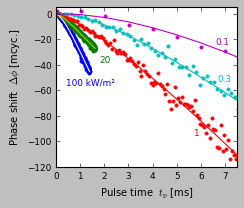

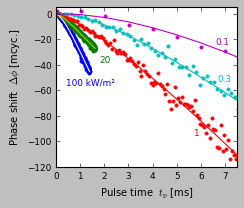

In [13]:
with mpl.rc_context(rcParams):
    fig, ax = plt.subplots(figsize=(3.1, 2.65))
    lines = []
    for intensity, fh in reversed(fhs.items()):
        lines.extend(ax.plot(fh['data/t'], fh['data/y'], '.'))

    for i, ((intensity, pk), color) in enumerate(zip(reversed(pks.items()), ['w', 'y', 'r', 'c', 'm'])):
        ax.plot(pk.t, pk.y_fit[0](50), color)

    ax.set_xlim(0, 7.5)
    ax.set_ylim(-120, 5)
    ax.text(0.4, -56,  u'100 kW/m²', color='b', fontsize=size)
    ax.text(1.8, -38, '20', color='g', fontsize=size)
    ax.text(5.7, -95, '1', color='r', fontsize=size)
    ax.text(6.6, -24, u'0.1', color='m', fontsize=size)
    ax.text(6.7, -53, u'0.3', color='c', fontsize=size)
    ax.set_xlabel(r"Pulse time  $t_\mathrm{p}$ [ms]",)
    ax.set_ylabel(r"Phase shift  $\Delta \phi$ [mcyc.]", )
    fig.tight_layout()
#     fig.savefig('../figs/04c-all-intensities.pdf', bbox_inches='tight', transparent=True)
fig

# 100 sun comparison

In [14]:
lightpurple = '#ed0dd9'
gold = '#dbb40c'

In [39]:
df_times = gr_df['data/t'][:]
dt_df = 0.015
t_neg = np.arange(gr_df['data/y_neg'][:].size) * 0.015 - (dt_df * (gr_df['data/y_neg'][:].size)) + gr_df['data/t'][0]
df_all_t = np.r_[t_neg, df_times]
df_all = np.r_[gr_df['data/y_neg'][:], gr_df['data/y'][:]]

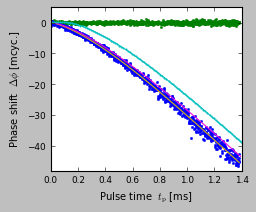

In [52]:
with mpl.rc_context(rcParams):
    fig, ax = plt.subplots(figsize=(3.25, 2.7))
    intensity = 100
    gr = fhs[intensity]
    pk = pks[intensity]
    gr_df = livefh[intensity]
    ax.plot(gr['data/t'], gr['data/y_control'], 'g.', markersize=4)
    ax.plot(gr['data/t'], gr['data/y'], 'b.', markersize=4)
    dphi_out = p.fh_exp_doub2dphi(gr_df)
    dphi_out_p = p.percentile_func(dphi_out)
    ax.plot(pk.t,  pk.y_fit[0](50), '-', color='#dbb40c', linewidth=1)
    ax.fill_between(pk.t, pk.y_fit[0](15.9), pk.y_fit[0](84.1), color='y', alpha=0.3)
    t = gr_df['data/t'][:]
    ax.plot(t, dphi_out_p(50), '-', color='#ed0dd9', linewidth=1)
    ax.plot(df_all_t+delta_t_ms, np.cumsum(df_all) * dt_df, color='c', marker='.', markersize=2.5)
#     ax.fill_between(pk.t, pk.y_fit[0](50) - pk.sigma[0](50),  pk.y_fit[0](50) + pk.sigma[0](50),
#                    color='b', alpha=0.3, zorder=10)
    ax.set_xlabel(r"Pulse time  $t_\mathrm{p}$ [ms]")
    ax.set_ylabel(r"Phase shift  $\Delta \phi$ [mcyc.]")
    ax.set_ylim(-48, 5)
    ax.set_xlim(0, 1.4)
    fig.tight_layout()
    fig.savefig('ex.pdf', bbox_inches='tight', transparent=True)

In [53]:
!open ex.pdf

In [10]:
with mpl.rc_context(rcParams):
    fig, ax = plt.subplots(figsize=(3.25, 2.55))
    intensity = 100
    gr = fhs[intensity]
    pk = pks[intensity]
    gr_df = livefh[intensity]
    df_out = p.fh_exp_doub2df(gr_df)
    df_out_p = p.percentile_func(df_out)
    t = gr_df['data/t'][:]
    dt = np.mean(np.gradient(t))
    offset = gr_df['data/offset'].value
    all_y = np.r_[gr_df['data/y_neg'][:],gr_df['data/y'][:]] + offset
    all_err = np.r_[gr_df['data/y_neg_err'][:],gr_df['data/y_err'][:]]
    all_t = (np.arange(-all_y.size, 0)+1)*dt + t[-1]
    
    ax.plot(np.r_[[-0.3, 0], pk.t],  np.r_[[0, 0], pk.df[0](50)]+offset, color='#dbb40c')
    ax.plot(np.r_[[-0.3, 0], t], np.r_[[0, 0], df_out_p(50)]+offset, '-', color='#ed0dd9')
    ax.fill_between(np.r_[[-0.3, 0], pk.t], np.r_[[0, 0], pk.df[0](15.9)]+offset, np.r_[[0, 0], pk.df[0](84.1)]+offset, color='y', alpha=0.3)
    ax.fill_between(np.r_[[-0.3, 0], t], np.r_[[0, 0], df_out_p(15.9)]+offset, np.r_[[0, 0], df_out_p(84.1)]+offset, color='#ed0dd9', alpha=0.3)
    ax.plot(all_t, all_y, 'b-')
    ax.fill_between(all_t, all_y - all_err, all_y + all_err,
                   color='b', alpha=0.3)
    ax.set_xlim(-0.3, 1.4)
    ax.set_xticks(np.arange(-0.3, 1.4, 0.3))
    ax.set_yticks(xrange(-200, -155, 10))
    ax.set_xlabel("Time [ms]",)
    ax.set_ylabel(r"$\Delta f$ [Hz]",)
    fig.tight_layout()
    fig.savefig('../figs/04c-df.pdf', bbox_inches='tight', transparent=True)

# Comparison 

In [11]:
df_infs = OrderedDict()
for intensity, pk in pks.items():
    df = p.percentile_func(pk.grs[0]['params/df_inf'][:])
    df_infs[intensity] = (df(15.9), df(50), df(84.1))
df_infs_array = np.array(df_infs.values())

In [12]:
df_infs = OrderedDict([(key, val['params/df_inf'].value) for key, val in fhs.items()])
df_inf_mu = OrderedDict([(key, np.mean(val)) for key, val in df_infs.items()])
df_inf_sigma = OrderedDict([(key, np.std(val, ddof=1)) for key, val in df_infs.items()])

In [13]:
Ihv = np.array(df_infs.keys())
r_pk = np.array([np.mean(fh['params/df_ratio'][:]) for fh in fhs.values()])
r_pk_sig = np.array([[np.mean(fh['params/df_ratio'][:]) - np.percentile(fh['params/df_ratio'][:], 15), np.percentile(fh['params/df_ratio'][:], 85)-np.mean(fh['params/df_ratio'][:])] for fh in fhs.values()])
r_pk_df = np.array([np.mean(fh['params/df_ratio'][:]) for fh in livefh.values()])
r_pk_sig_df = np.array([[np.mean(fh['params/df_ratio'][:]) - np.percentile(fh['params/df_ratio'][:], 15), np.percentile(fh['params/df_ratio'][:], 85)-np.mean(fh['params/df_ratio'][:])] for fh in livefh.values()])

In [14]:
df_infs1 = OrderedDict([(key, val['params/df_inf'].value) for key, val in livefh.items()])
df_inf_mu1 = OrderedDict([(key, np.mean(val)) for key, val in df_infs1.items()])
df_inf_sigma1 = OrderedDict([(key, np.std(val, ddof=1)) for key, val in df_infs1.items()])

# Frequency shift comparison

In [15]:
with mpl.rc_context(rcParams):
    fig, (ax, ax2) = plt.subplots(figsize=(6.5, 3), ncols=2)
    ax.semilogx(np.array(df_infs.keys()), -df_infs_array[:, 1], 'b.', linestyle='-')
    ax.errorbar(df_infs.keys(), -df_infs_array[:, 1], yerr=abs(df_infs_array[:, (0, 2)].T-df_infs_array[:, 1]), fmt='none')
    ax.semilogx(np.array(df_inf_mu1.keys()), -1*np.array(df_inf_mu1.values()), 'g.', linestyle='-')
    ax.errorbar(np.array(df_inf_sigma1.keys()), np.array(df_inf_sigma1.values()), fmt='none')
    ax.set_xlim(0.08, 120)
    ax.set_ylim(0, 45)
    ax.set_yticks(np.arange(5)*10)
    ax.text(1, 10, "tr-EFM", color='g')
    ax.text(1, 25, "phasekick", color='b')
    ax.set_xlabel(u"Intensity [kW/m²]")
    ax.set_ylabel(r"$\Delta f_\infty$ [Hz]")
    ax2.semilogx(Ihv, r_pk, 'b.', linestyle='-')
    ax2.errorbar(Ihv, r_pk, yerr=r_pk_sig.T, fmt='none')
    ax2.semilogx(Ihv, r_pk_df, 'g.', linestyle='-')
    ax2.errorbar(Ihv, r_pk_df, yerr=r_pk_sig_df.T, fmt='none')
    ax2.text(0.14, 0.2, "tr-EFM", color='g')
    ax2.text(0.35, 0.83, "phasekick", color='b')
    ax2.set_xlabel(u"Intensity [kW/m²]")
    ax2.set_ylabel(u"$r$")
    ax2.set_xlim(0.08, 120)
    ax2.set_ylim(0, 1)

In [16]:
fig.tight_layout()

In [17]:
fig.savefig('../figs/SI-010-df_inf-vs-intensity.pdf', bbox_inches='tight')

# Live Frequency shift

In [18]:
tau_012 = np.zeros((all_intens.size, 3, 2))
for i, row in enumerate(tau_012):
    gr = livefh.values()[i]
    tau_p = p.percentile_func(gr['params/tau'][:])
    row[:] = np.array([tau_p(15.9), tau_p(50), tau_p(84.1)])

In [19]:
tau_dphi = np.zeros((all_intens.size, 3, 2))
for i, row in enumerate(tau_dphi):
    gr = fhs.values()[i]
    tau_p = p.percentile_func(gr['params/tau'][:])
    row[:] = np.array([tau_p(15.9), tau_p(50), tau_p(84.1)])

In [20]:
with mpl.rc_context(rcParams):
    fig, ax = plt.subplots(figsize=(3.1, 2.5))
    ax.loglog(all_intens, tau_dphi[:, 1, 0], 'b.', linestyle='-')
    ax.loglog(all_intens, tau_dphi[:, 1, 1], 'b.', fillstyle='none', linestyle='--')
    ax.loglog(all_intens, tau_012[:, 1, 0], 'g.', linestyle='-')
    ax.loglog(all_intens, tau_012[:, 1, 1], 'g.', fillstyle='none', linestyle='--')
    ax.errorbar(all_intens, tau_dphi[:, 1, 0],
                yerr=error(tau_dphi[:, :, 0]),
                fmt='none', ecolor='b')
    ax.errorbar(all_intens, tau_dphi[:, 1, 1],
                yerr=error(tau_dphi[:, :, 1]),
                fmt='none', ecolor='b')
    ax.errorbar(all_intens, tau_012[:, 1, 0],
                yerr=error(tau_012[:, :, 0]),
                fmt='none', ecolor='g')
    ax.errorbar(all_intens, tau_012[:, 1, 1],
                yerr=error(tau_012[:, :, 1]),
                fmt='none', ecolor='g')
    ax.set_ylim(0.001, 50)
    ax.set_xlim(0.08, 125)
    ax.set_xlabel(u"Intensity [kW/m²]")
    ax.set_ylabel(r"$\tau$ [ms]")
    fig.tight_layout()
    fig.savefig(
'../figs/04d-time-constants.pdf',
bbox_inches='tight',
transparent=True)